# Projekt Voki: vocabulary cards extraction

# 1) Azure OCR
based of the scanned vocabulary pages, we send a pdf of each book to azure in order to run OCR

## imports 

In [1]:
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from dotenv import dotenv_values
from array import array
from pathlib import Path
import glob
import json

## Settings

In [2]:
config = dotenv_values(".env") # API secrets
root = Path.cwd().parent # project root
data_dir = root / 'data'
ocr_json_file = data_dir / 'azure_results.json'

## Functions

In [51]:
def get_files(folder,suffix):
    files = []
    for file in glob.glob(str(folder) + '/*' + suffix):
        files.append(file)
    return files

def azure_ocr_multifile(files,client):
    start_time = time.time()
    filedict = dict()
    for file in files:
        filedict[file] = azure_ocr(file,client)
    return filedict

def azure_ocr(file,client):
    # Open the file
    print(f'Azure OCR processing: {file}')
    read_image = open(file, "rb")

    # Call API with image and raw response (allows you to get the operation location)
    read_response = computervision_client.read_in_stream(read_image, raw=True)
    # Get the operation location (URL with ID as last appendage)
    read_operation_location = read_response.headers["Operation-Location"]
    # Take the ID off and use to get results
    operation_id = read_operation_location.split("/")[-1]

    # Call the "GET" API and wait for the retrieval of the results
    while True:
        read_result = computervision_client.get_read_result(operation_id)
        if read_result.status.lower () not in ['notstarted', 'running']:
            break
        print ('Waiting for result...')
        time.sleep(10) #10
    print(f'added {file} result')
    return read_result


## run azure OCR

In [56]:
# get files
data_dir = root / 'data'
files = get_files(data_dir,'.pdf')

# set up azure client
computervision_client = ComputerVisionClient(config.get('ENDPOINT'), 
                                             CognitiveServicesCredentials(config.get('APIKEY')))

# query OCR service
azure_results = azure_ocr_multifile(files,computervision_client)

# postprocess results (into json)
azure_json = {key:val.as_dict() for key, val in azure_results.items()}

# save to disk
with open(ocr_json_file,'w') as fh:
    json.dump(azure_json,fh)

Azure OCR processing: C:\coding\voki\data\SerieVertes1.pdf
Waiting for result...
Waiting for result...
added C:\coding\voki\data\SerieVertes1.pdf result
Azure OCR processing: C:\coding\voki\data\SerieVertes2.pdf
Waiting for result...
added C:\coding\voki\data\SerieVertes2.pdf result
Azure OCR processing: C:\coding\voki\data\SerieVertes3.pdf
Waiting for result...
added C:\coding\voki\data\SerieVertes3.pdf result
Azure OCR processing: C:\coding\voki\data\SerieVertes4.pdf
Waiting for result...
added C:\coding\voki\data\SerieVertes4.pdf result


# 2) extract vocabulary data
## imports

In [3]:
import fitz
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2
import numpy as np
import pandas as pd
import hashlib
import re

%matplotlib inline

## Functions

In [115]:
def myimshow(im,h=12,w=8):
    plt.figure(figsize=(w,h))
    plt.imshow(im)
    plt.show()
    
def gridshow(imgs,h=12,w=8):
    n=len(imgs)    
    fig, axes = plt.subplots(nrows=1, ncols=n, sharey='row', figsize=(h*n, h*2))
    for j, ax in enumerate(axes):
        ax.imshow(imgs[j])
        ax.set_xticks([])
        ax.set_yticks([])
    
def getpage(data,n):
    if n<0:
        raise Exception(f'n ({n}) must be 0 or larger')
    if n< len(data['analyze_result']['read_results']): 
        return data['analyze_result']['read_results'][n]
    else: raise Exception(f"n ({n}) must be smaller than the number of pages ({len(data['analyze_result']['read_results'])})")
    
def box_to_polygon(box,w_inch,h_inch,w_pix,h_pix):
    box = np.array(box)
    return np.array([[x,y] for x,y, in zip(box[::2]/w_inch*w_pix,box[1::2]/h_inch*h_pix)])

def rotate_image(image, angle, center):
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def rotate_point(p,alpha,p0):
    x = p[0]
    y = -p[1]
    x0 = p0[0]
    y0 = -p0[1]
    x1 = (x-x0)*np.cos(np.deg2rad(alpha)) - (y-y0)*np.sin(np.deg2rad(alpha)) + x0
    y1 = (x-x0)*np.sin(np.deg2rad(alpha)) + (y-y0)*np.cos(np.deg2rad(alpha)) + y0
    return np.array([x1,-y1])

def rotate_polygon(polygon,angle,center):
    result = []
    for p in polygon:
        result.append(rotate_point(p,angle,center))
    return np.array(result)

def images_from_pdf_fitz(file,zoom = 2):
    images = []
    mat = fitz.Matrix(zoom, zoom)
    doc = fitz.open(file)
    for page in doc:
        pix = page.get_pixmap(matrix = mat)
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        images.append(img)
    return images

def preprocess_document(document_images,document_data):
    results=[]
    for i, image in enumerate(document_images):
        page_data = getpage(document_data,i)
        results.append(preprocess_page(image,page_data))
    return results

def preprocess_page(page_im,page_data):
    w_inch=page_data['width']
    h_inch=page_data['height']
    angle = page_data['angle']
    
    im=deepcopy(page_im)
    im = np.array(im) 
    im = im[:, :, ::-1]
    h_pix ,w_pix,_ = im.shape
    image_center = (h_pix/2,w_pix/2)
    im_rotated = rotate_image(im, angle, image_center)
    im = deepcopy(im_rotated)
    
    line_polygons=[]
    word_polygons=[]

    for line in page_data['lines']:
        # add line info
        line_polygon = box_to_polygon(line['bounding_box'],w_inch,h_inch,w_pix,h_pix)
        line_polygon = rotate_polygon(line_polygon,angle,image_center)
        line_polygon = np.round(line_polygon).astype(int)
        im=cv2.polylines(im, [line_polygon], True, (0,255,0), thickness=3)
        line_polygons.append(line_polygon)

        #add word info
        for word in line['words']:
            word_polygon = box_to_polygon(word['bounding_box'],w_inch,h_inch,w_pix,h_pix)
            word_polygon = rotate_polygon(word_polygon,angle,image_center)
            word_polygon = np.round(word_polygon).astype(int)

            #im=cv2.polylines(im, [word_polygon], True, (255,0,0), thickness=2)
            word_polygons.append(word_polygon)

    page_preprocessed= {
        'im_ocr_boxes':im,
        'im_raw':im_rotated,
        'w_inch':w_inch,
        'h_inch':h_inch,
        'h_pix':h_pix,
        'w_pix':w_pix,
        'line_polygons':line_polygons,
        'word_polygons':word_polygons
        }
    return page_preprocessed
    
def add_alpha_rectangle(src,pos,alpha=0.75,col=[255,0,0]):
    # ... to an image at place pos
    x_min, x_max, y_min, y_max = pos
    sub_img = src[y_min:y_max, x_min:x_max]
    s=sub_img.shape
    blend_vec = np.array(col,dtype=np.uint8)
    blend_mat = np.tile(blend_vec,(s[0],s[1],1))
    res = cv2.addWeighted(sub_img, alpha, blend_mat, 1-alpha, 0)
    src[y_min:y_max, x_min:x_max] = res
    return src

def apply_vertical_thresholds(df,props):
    # position based
    left_edge_start = df['x_min'] > props['x'][0]
    left_edge_end = df['x_min'] < props['x'][1]
    right_edge = df['x_max'] < props['x'][2]
    return left_edge_start & left_edge_end & right_edge

def identify_french_voki(df,props):
    df['french'] = apply_vertical_thresholds(df,props)
    # remove individual words
    bad_words = ['Exercices','Vocabulaire']
    df = df.drop(df[df['text'].isin(bad_words)].index)
    return df

def identify_german_voki(df,props):
    df['german'] = apply_vertical_thresholds(df,props)
    return df
    
def identify_sentence(df,props):
    df['sentence'] = apply_vertical_thresholds(df,props)
    return df

def clean_df_1(df):
    bad_texts = ['VOCABULAIRE']
    df = df[~df['text'].isin(bad_texts)]
    return df

def make_page_df(results_dict_page,raw_data_page,fname):
    dfs=[]

    # get data for one page
    h_pix = results_dict_page['h_pix']
    w_pix = results_dict_page['w_pix']

    # go through all lines and record the coordinates
    for j,line in enumerate(raw_data_page['lines']):
        df_dict = {}
        box_points = results_dict_page['line_polygons'][j]
        x_min = np.min(box_points[:,0])
        x_max = np.max(box_points[:,0])
        y_min = np.min(box_points[:,1])
        y_max = np.max(box_points[:,1])
        df_dict = {'text': [line['text']],
                   'x_min' : [x_min],
                   'x_max': [x_max],
                   'y_min': [y_min],
                   'y_max': [y_max],
                   'height': [y_max - y_min],
                   'width': [x_max - x_min],
                   'confidence': [safe_get(line,['appearance','style','confidence'],fallback=np.nan)],
                   'polygone': [box_points],
                   'word_texts': [[word['text'] for word in line['words']]],
                   'word_confidences': [[word['confidence'] for word in line['words']]],
                   'page': [raw_data_page['page']],
                   'page_angle': [raw_data_page['angle']], 
                   'words':[line['words']],
                   'file': fname,
                   }
        dfs.append(pd.DataFrame(df_dict))
    return dfs

def safe_get(obj,keys,fallback=None):
    for key in keys:
        obj = obj.get(key)
        if obj is None:
            return fallback
    return obj

def undo_linebreak(row,dF,append_counter):
    delta_y = 20 # empirically measured
    if not abs(row['y_min'] - dF.iloc[0]['y_min'] - append_counter*delta_y) < 15:
        return dF
    
    text = dF.iloc[0]['text']
    if text.endswith('-'):
        dF['text'] = [''.join([text.strip('-'),row['text']])]
    else:
        dF['text'] = [' '.join([text,row['text']])]
    dF['polygone'] = [np.append(dF.iloc[0]['polygone'],row['polygone'],axis=0)]
    dF['word_texts'] = [deepcopy_extend_lists(dF.iloc[0]['word_texts'],row['word_texts'])]
    dF['words'] = [deepcopy_extend_lists(dF.iloc[0]['words'],row['words'])]
    dF['word_confidences'] = [deepcopy_extend_lists(dF.iloc[0]['word_confidences'],row['word_confidences'])]
    dF['line_appended'] = [True]
    return dF

def deepcopy_extend_lists(a,b):
    c=a.copy()
    d=b.copy()
    c.extend(d)
    return c

def post_processing_df(df):
    
    df["id"] = df.index

    df = df[df['text'].str.len()>1] # single chars
    df = df[df['y_max']<canvas_end[1]]
    df = identify_french_voki(df,props['left']) 
    df = identify_german_voki(df,props['right']) 
    df = identify_sentence(df,props['center']) 
    df['label']=df[labels].dot(df[labels].columns)
    df = clean_df_1(df)
    return df

def adjust_line_continuations(df_page,props):
    # obtains the median x value of each language's column, and from
    # there deduces if a line is a new or continued lin
    
    labels = props['labels']
    df_temp = df_page.sort_values(by=['y_max','label'])
    df_labels = {label:df_temp[df_temp['label']==label] for label in labels}
    page_medians = {}
    df_page_new=[]
    for label in labels:
        median_xmin = np.round(df_labels[label]['x_min'].median()).astype(int)
        page_medians[label]=median_xmin
        result_rows = []
        append_counter = 0
        
        for j, row in df_labels[label].iterrows():
            if row['x_min'] > median_xmin + delta_median: # this is a continued line
                append_counter +=1
                try:
                    result_rows[-1] = undo_linebreak(row, result_rows[-1],append_counter)
                except IndexError as e:
                    pass
            else: # this is a new line
                append_counter = 0
                try:
                    result_rows.append(pd.DataFrame(row).transpose())
                except ValueError as e:
                    pass
        try:
            df_page_new.append(pd.concat(result_rows))
        except ValueError as e:
            pass
    return df_page_new, page_medians
    
def join_languages(df_page,mergecols):
    df_german = df_page[df_page['german']]
    df_french = df_page[df_page['french']]
    df_sentence = df_page[df_page['sentence']]
    
    
    df3 = pd.merge_asof(df_french.sort_values(by='y_max'),
                 df_german[['id','y_max']].sort_values(by='y_max'),
                 on='y_max',
                 suffixes=['_f','_g'],
                 direction = 'nearest',
                 tolerance=15)

    df4=pd.merge_asof(df3.sort_values(by='y_max'),
                 df_sentence[['id','y_max']].sort_values(by='y_max'),
                 on='y_max',
                 suffixes=['','_s'],
                 direction = 'nearest',
                 tolerance=15)

    df4 = df4.rename(columns={'id':'id_s'})
    for col in ['id_g','id_s']:
        df4[col]=df4[col].fillna(-1).astype("int64")


    df4 = df4.merge(df_german[mergecols],
                      how='left',
                      left_on='id_g',
                      right_on='id',
                      suffixes=['','_g'],
                     )
    df4=df4.drop(columns='id')

    df4 = df4.merge(df_sentence[mergecols],
                      how='left',
                      left_on='id_s',
                      right_on='id',
                      suffixes=['','_s'],
                     )
    df4=df4.drop(columns='id')
    for col in ['y_max_g','x_min_g','y_max_s','x_min_s']:
        df4[col]=df4[col].fillna(-1).astype("int64")
        
    return df4

In [113]:
pd.set_option('display.max_columns', None)

# some constants, found with tideous try & error
props = {'columns': {'left': 
                     {'x':[170,260,5000],
                      'col':(0, 128, 128)},
                     'right':
                     {'x':[750,850,1050],
                      'col':(128, 0, 128)},
                     'center':
                     {'x':[410,500,850],
                      'col':(128, 128, 128)}
                    },
         'delta_y_linebreak': 18, # pixel
         'delta_median': 10,
         'labels': ['french','german','sentence'],
         'canvas_start' : (170,100),
         'canvas_end' : (1050,1300),
         'canvas_color' : (0,0,128),
        }

## pipeline

In [82]:
# get pdf and json files
with open(ocr_json_file,'r') as fh:
    data_raw=json.load(fh)
    
files = list(data_raw.keys())
    
images={}  
results_dict={}
dfs = []

for file, file_ocr_data in data_raw.items():
    print(f'processing {file} ...')
    
    # get images from pdf files
    images[file] = images_from_pdf_fitz(file,zoom=2)
    
    # preprocess. i.e. rotate, inch2pixel, extract entity polygons
    results_dict[file] = preprocess_document(images[file],
                                             file_ocr_data)   
    
    # DataFrame-ifying the azure results
    for page in range(len(results_dict[file])):

        dfs.extend(make_page_df(results_dict[file][page],
                                getpage(data_raw[file],page),
                                file
                               )
                  )
           
            
df = pd.concat(dfs).reset_index(drop=True)

    

processing C:\coding\voki\data\SerieVertes1.pdf ...
processing C:\coding\voki\data\SerieVertes2.pdf ...
processing C:\coding\voki\data\SerieVertes3.pdf ...
processing C:\coding\voki\data\SerieVertes4.pdf ...


In [87]:
# add language labels & basic cleaning
df2 = post_processing_df(df)
#check that no field was double labeled
print('unique language check')
print(df2[['french','german','sentence']].sum(axis=1).value_counts())

unique language check
1    13564
0     1866
dtype: int64


In [116]:
# adjust for line continuations
pd.set_option('mode.chained_assignment', None)

dfs = []
for file in files:
    df_file = df2[df2['file']==file]
    for pagenum in df_file.page.unique():
        df_page = df_file[df_file['page']==pagenum]
        adjusted, medians = adjust_line_continuations(df_page,props)
        dfs.append(pd.concat(adjusted))
        results_dict[file][pagenum-1]['medians']=medians
        
        
pd.set_option('mode.chained_assignment', 'raise')

df_3 = pd.concat(dfs)

intcols = ['id','page','width','x_max', 'x_min', 'y_max', 'y_min']
floatcalls = ['confidence','page_angle']
for col in intcols:
    df_3[col] = df_3[col].astype(int)
for col in floatcalls:
    df_3[col] = df_3[col].astype(float)

In [117]:
# match french words with sentences & translations

dfs = []
mergecols = ['id','y_max','x_min','text','polygone']

for file in files:
    df_file = df_3[df_3['file']==file]
    for pagenum in df_file.page.unique():
        df_page = df_file[df_file['page']==pagenum]
        dfs.append(join_languages(df_page,mergecols))
        
        
        
df_7 = pd.concat(dfs)

In [119]:
# post processing
# remove lautschrift
df_7['text'] = df_7['text'].replace('(\[.*\])','',regex=True).str.strip()

# remove "french" voki that does not have agerman partner
df_7['dropme'] = df_7.text_g.isna() & df_7.text_s.isna()

# no hash is required befor the manual checks of the vocabuary
# df_7['hash'] = [hashlib.md5(val).hexdigest() for val in df_7['text'].apply(lambda x: x.encode('utf-8'))]

# save to disc
fname = 'voki_export_full_db.csv'
df_7[~df_7['dropme']][['text','text_g','text_s','y_max','page','file']].to_csv(fname,index=False,sep=';',encoding='utf-8-sig')



# vizualize processing steps
## make images with language labels

In [124]:
delta_median = 10

label_colors = [[255,0,0],
                [0,0,255],
                [0,255,0]]

extension_colors =  [[255,150,150],
                    [150,150,255],
                    [150,255,150]]

labels = ['french','german','sentence']
line_thickness = 2

for file in files:
    df_file = df_3[df_3['file']==file]
    for pagenum in df_file.page.unique():
        
        # get data for one page
        im=deepcopy(results_dict[file][pagenum-1]['im_raw'])

        # add canvas info
        im = cv2.rectangle(im, canvas_start, canvas_end, canvas_color, line_thickness)
        for prop,vals in props['columns'].items():
            for x in vals['x']:
                im = cv2.line(im, 
                              (x, props['canvas_start'][1]), 
                              (x, props['canvas_end'][1]),
                              (200,200,0), 
                              thickness=line_thickness)

        df_page = df_file[df_file['page']== pagenum]

        for label in labels:
            median_xmin = results_dict[file][pagenum-1]['medians'][label]
            im = cv2.line(im, (median_xmin, props['canvas_start'][1]), (median_xmin, props['canvas_end'][1]), (200,0,200), thickness=line_thickness)
            im = cv2.line(im, (median_xmin+props['delta_median'], props['canvas_start'][1]), 
                              (median_xmin+props['delta_median'], props['canvas_end'][1]), 
                              (200,100,200), thickness=line_thickness)

        # add langage labels
        for j, row in df_page.iterrows():
            for k, label in enumerate(labels):
                if row[label]:
                    if row['x_min'] < results_dict[file][pagenum-1]['medians'][label]+props['delta_median']:
                        color = label_colors[k]
                    else:
                        color = extension_colors[k]
                    im = add_alpha_rectangle(im, 
                                             [row['x_min'],row['x_max'],row['y_min'],row['y_max']],
                                             col=color)
                if row['label']=='':
                    im = add_alpha_rectangle(im, 
                                             [row['x_min'],row['x_max'],row['y_min'],row['y_max']],
                                             col=(50,50,50))
                    pass
        results_dict[file][pagenum-1]['medians']['im_language_labels'] = im


### plot those pages

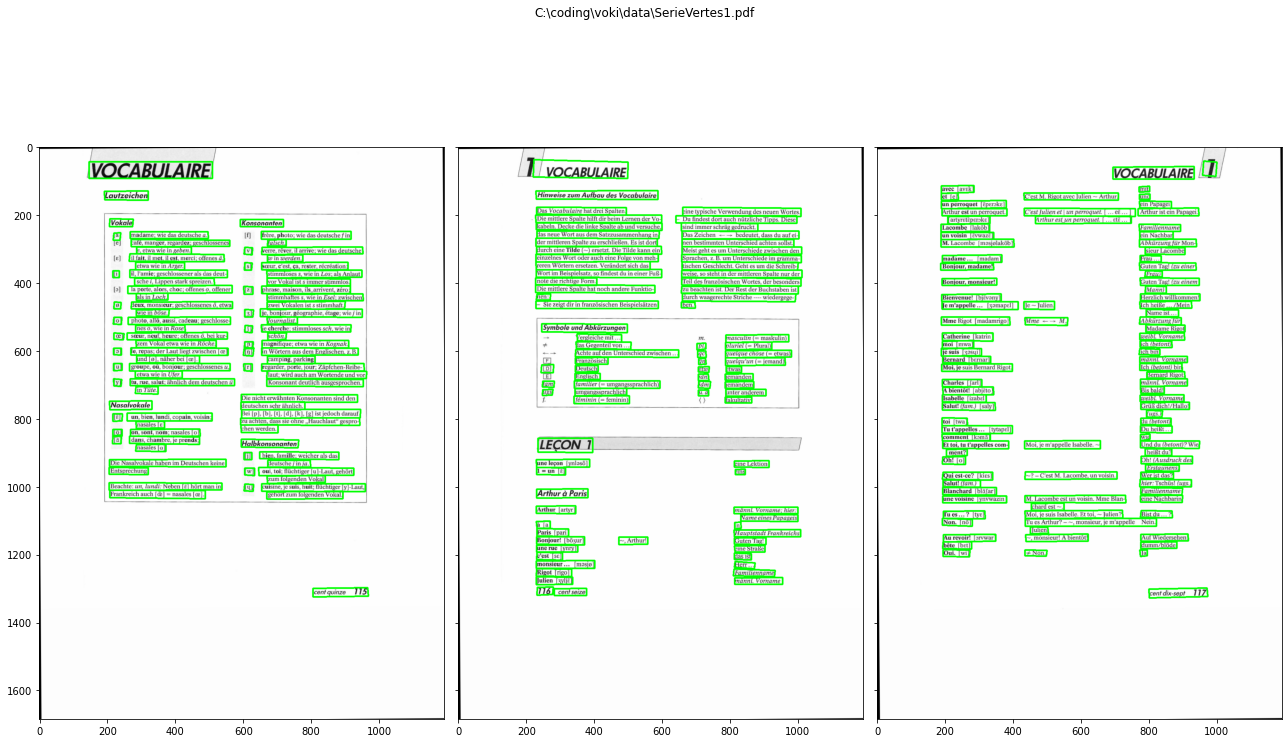

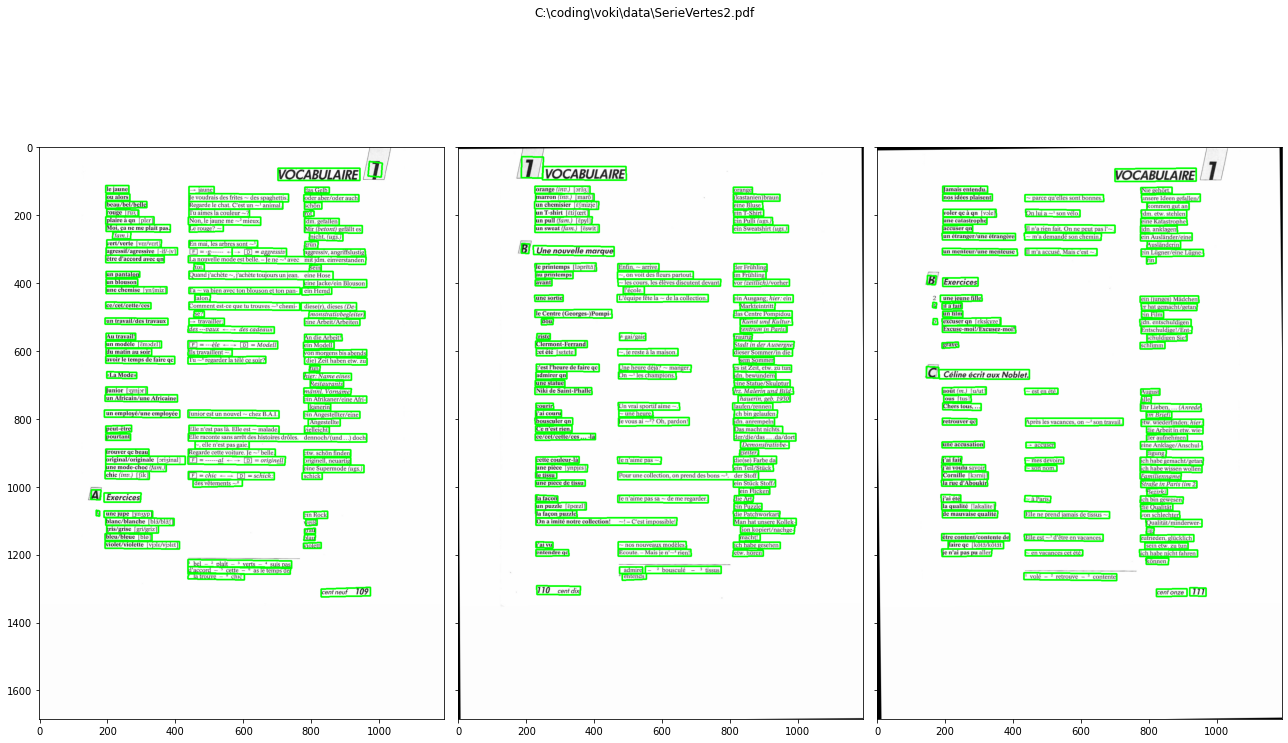

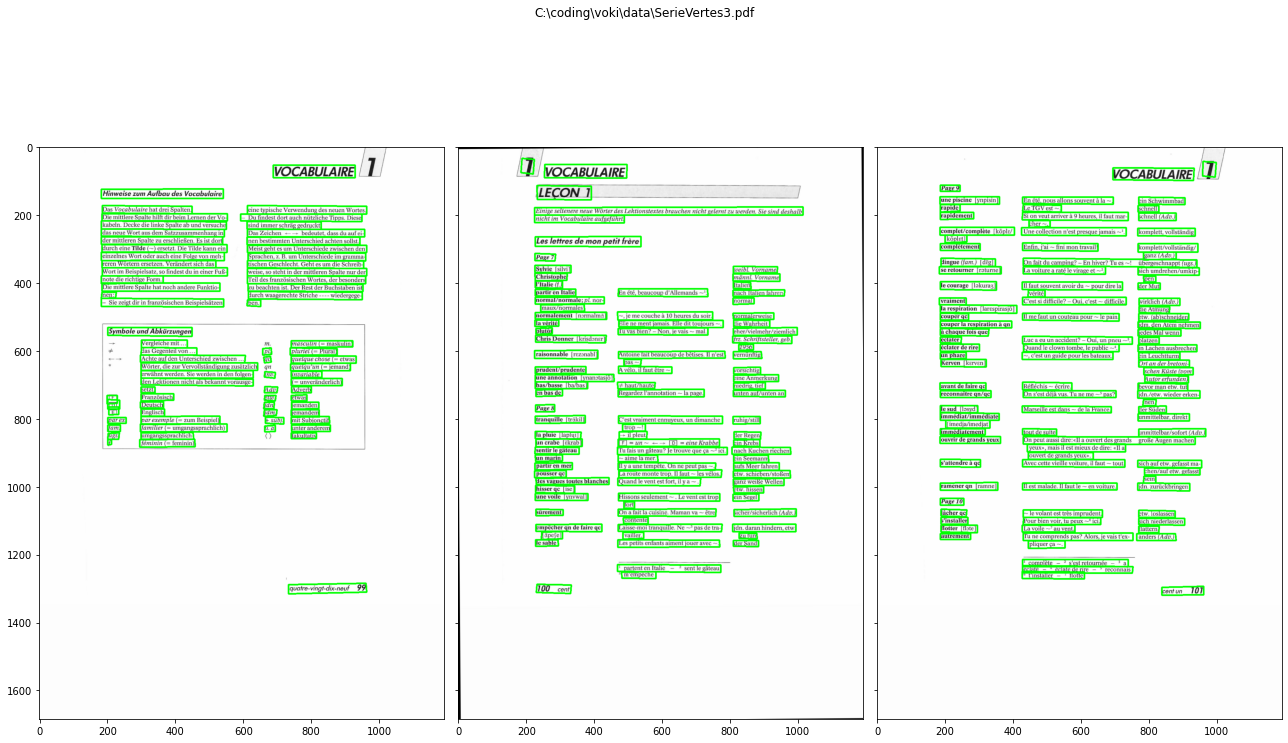

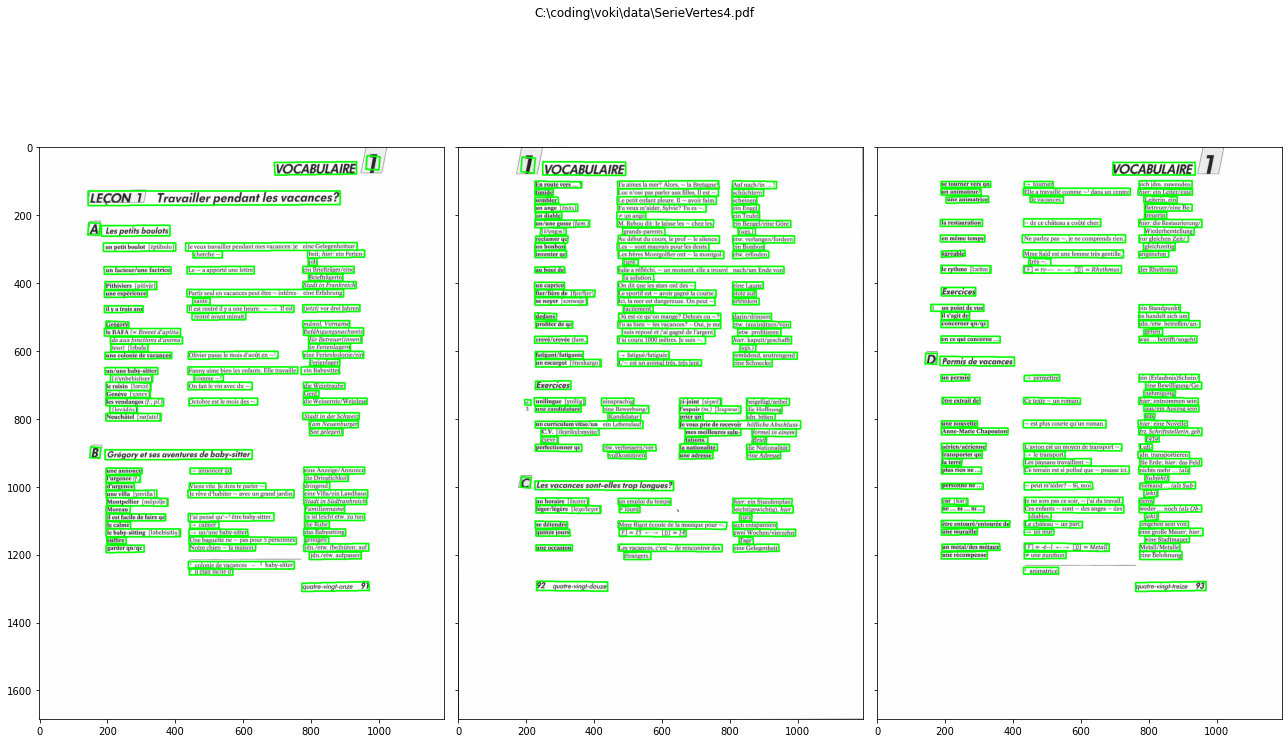

In [30]:
n = 3# number of images in one row
h = 6

for file in files:
    plot_images=[]
    for i_page,result in enumerate(results_dict[file][:3]):
        plot_images.append(results_dict[file][i_page]['im_ocr_boxes'])
        if i_page%n == n-1:
            fig, axes = plt.subplots(nrows=1, ncols=n, sharey='row', figsize=(h*n, h*2))
            fig.suptitle(file)
            for j, ax in enumerate(axes):
                ax.imshow(plot_images[j])
            fig.tight_layout()
            plot_images=[]

    

## figure out page column parameters
this is an empiric try- and error search

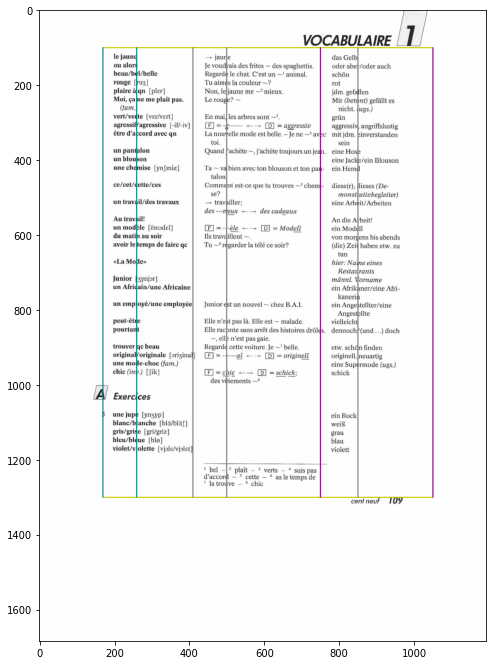

In [12]:
file = files[1]
i_page=0
im = deepcopy(results_dict[file][i_page]['im_raw'])
page_height,page_width,n_channels = im.shape
line_thickness = 2


im = cv2.rectangle(im, canvas_start, canvas_end, (200,200,0), line_thickness)

for prop,vals in props.items():
    for x in vals['x']:
        # im = cv2.line(im, (x, canvas_start[1]), (x, canvas_end[1]), vals['col'], thickness=line_thickness)
        im = cv2.line(im, (x, canvas_start[1]), (x, canvas_end[1]), vals['col'], thickness=line_thickness)
im_boxes = deepcopy(im)
myimshow(im)

## create tabular Dataframe of Lines

In [ ]:
file = files[3]
page = 0
len(results_dict[file])

### plot those images

In [ ]:
for result in results:
    myimshow(result['im_language_labels'])

## match french words with sentences & translations

### post processing of texts

## make images of merged vocables

In [14]:
poly_cols = ['polygone','polygone_g','polygone_s']
for i, pagenum in enumerate(df_7.page.unique()):


    # checkout that page's data
    df_page = df_7[df_7['page']==pagenum]
    im=deepcopy(results[i]['im_raw'])
    
    # add language labels
    for j, row in df_page.iterrows():
        if row['dropme']:continue
        
        for color,column in zip(label_colors, poly_cols):
            if row[column] is not np.nan:
                hull = cv2.convexHull(np.int32(row[column]), False)
                

                im = cv2.drawContours(im, [hull], 0, color, thickness = -1)
                im = cv2.drawContours(im, [hull], 0, (0,0,0), thickness = 3)
#                 im = cv2.polylines(im, hull, True, (0,0,0), thickness=2)
    
        
        # add connecting lines
        x1=row['x_min']
        y1=row['y_max']
        
        x3=row['x_min_s']
        y3=row['y_max_s']
        if x3 > 0 and y3 > 0:
            im = cv2.line(im, (x1, y1), (x3, y3), [0,200,100], thickness=3)
      
        x2=row['x_min_g']
        y2=row['y_max_g']
        if x2 > 0 and y2 > 0:
            im = cv2.line(im, (x1, y1), (x2, y2), [0,0,200], thickness=1)
    im = cv2.addWeighted(deepcopy(results[i]['im_raw']), 0.75, im, 0.25, 0)
    results[i]['im_hulls'] = im
# myimshow(results[1]['im_hulls'])

## show the progession of steps

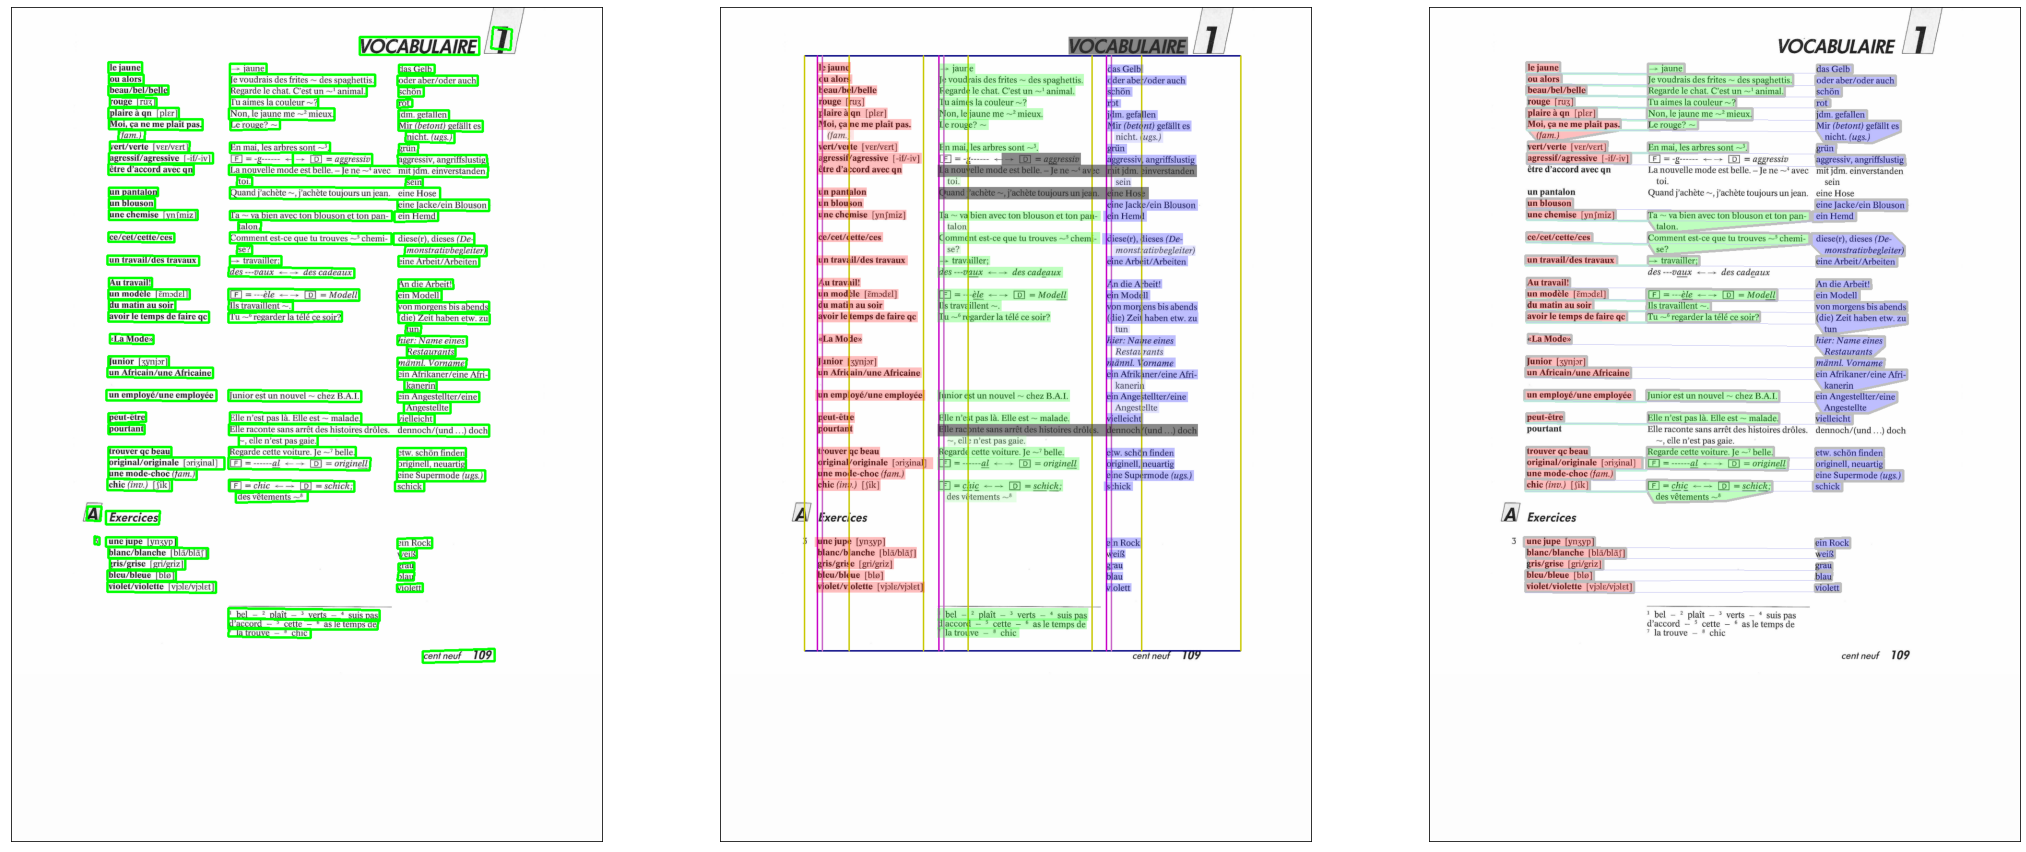

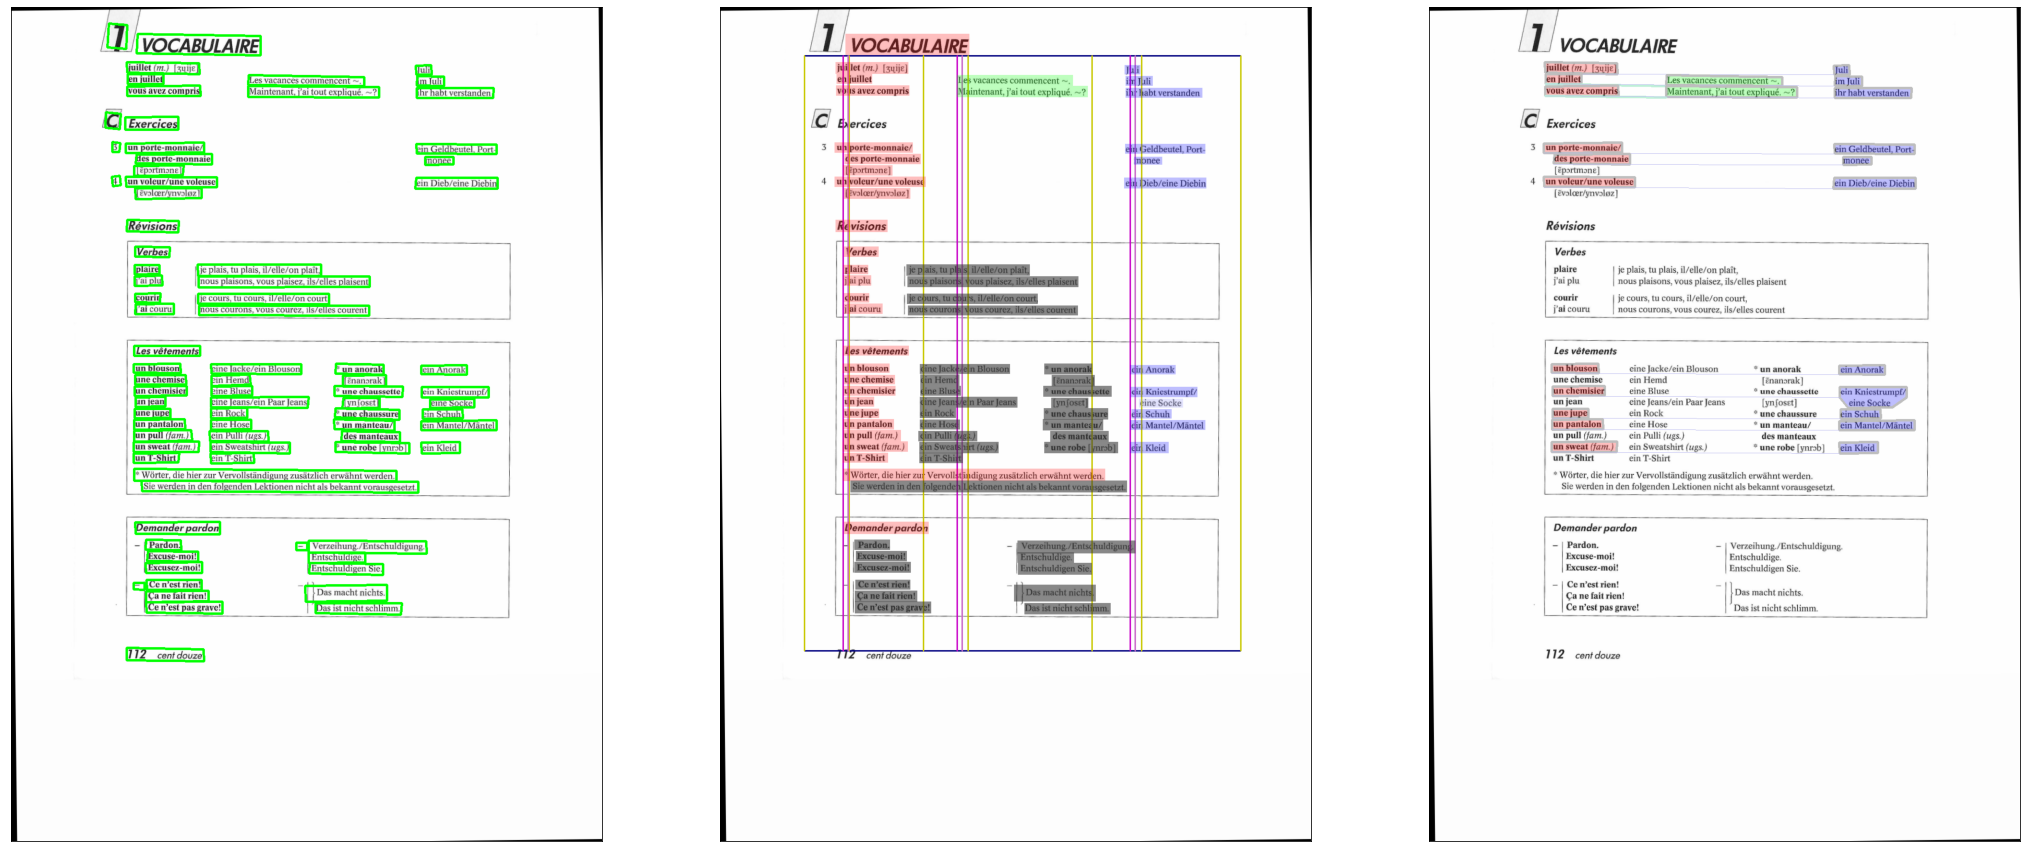

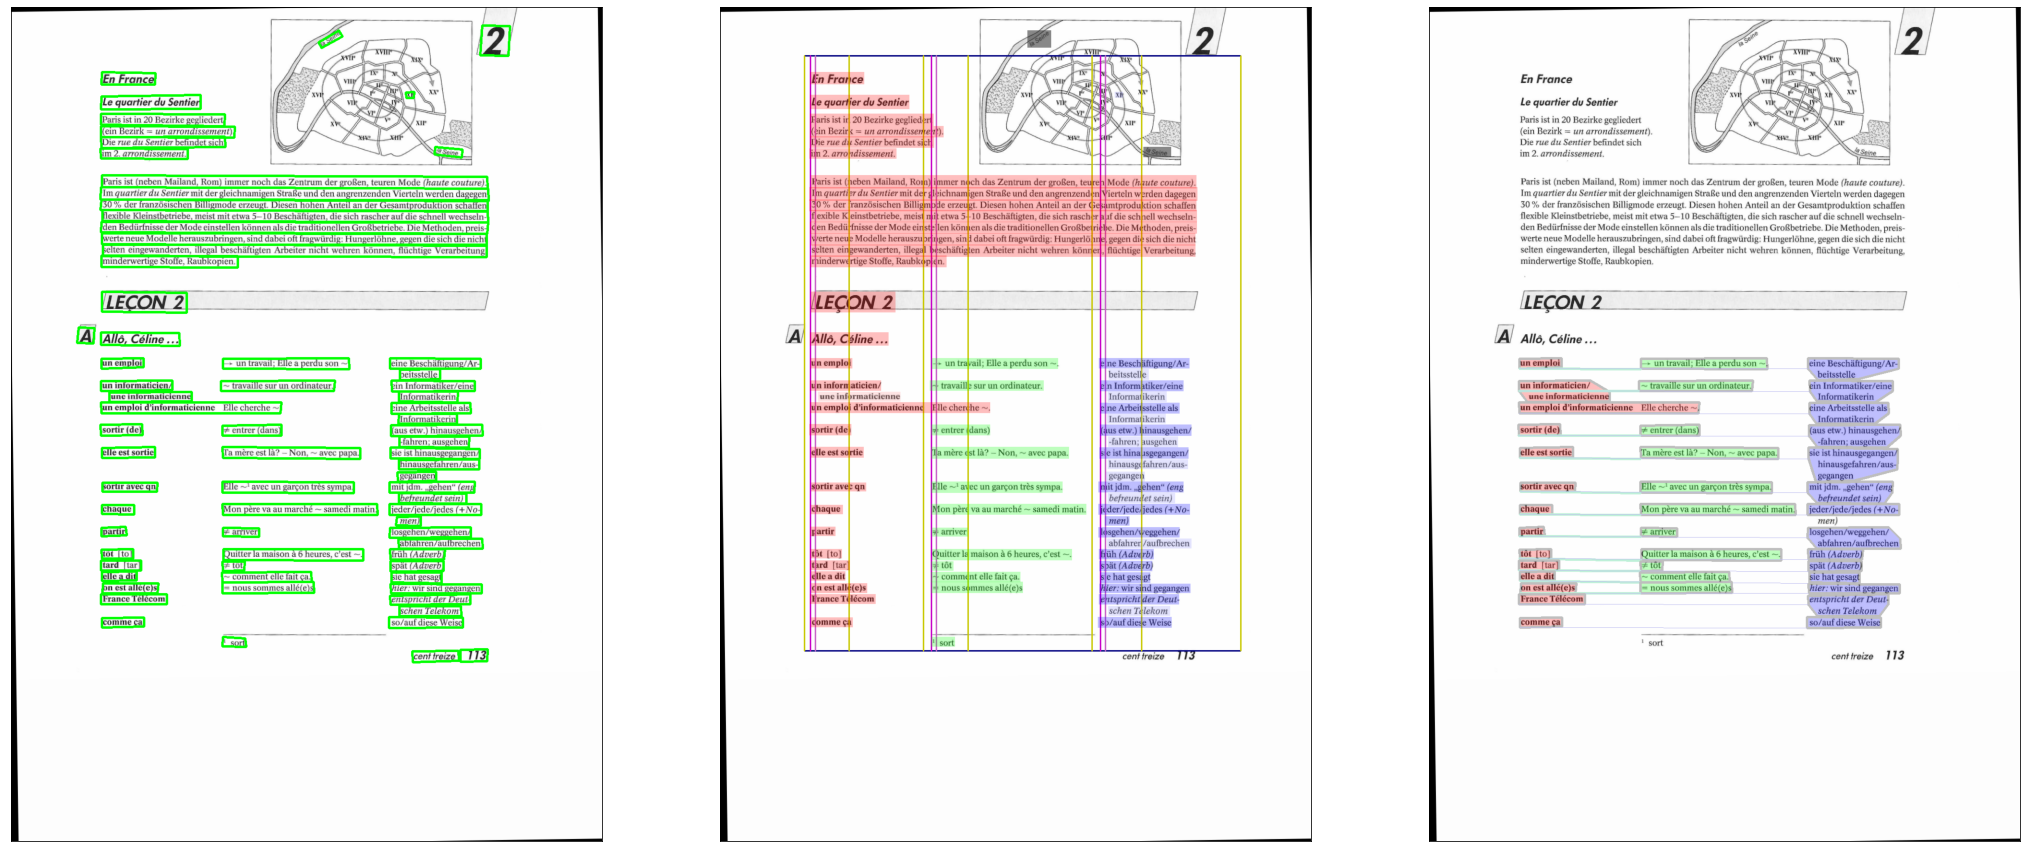

In [19]:
for i,result in enumerate(results):
    if i not in [0,3,4]:continue
    ims = [result['im'],
           result['im_language_labels'],
           result['im_hulls']]
    gridshow(ims)
